# 결과

+ best(mae:   1.525) : non-scaling elasticnet(alpha = 1)이 가장 결과가 좋았다
+ best2(mae : 1.5285) : robust-scaling svr(kernel= linear)
+ R에서 뽑은 변수들만 출력 :8개

["crm_wthr_눈","crm_clue_피해자신고","vic_age_2_30대","일인가구수"
    ,"총_인구수","기초수급_19세이하","기초수급_60세이상"
         ,"외국인수", "score_교통"]

In [3]:
import pandas as pd

#그래프에 한글 표현하기
import  matplotlib.pyplot as plt
import  matplotlib.font_manager as fm
import  matplotlib.font_manager as fm
font_name = fm.FontProperties(fname = "C:/Windows/Fonts/malgun.ttf").get_name()
plt.rc("font", family = font_name)



#마이너스 표시하기
import  matplotlib as mlp
mlp.rcParams["axes.unicode_minus"]  = False

import numpy as np
import pandas  as pd
import seaborn as sns
##회귀분석
import statsmodels.api as sm
# 정규화
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import  RFE
from lightgbm import LGBMClassifier,  LGBMRegressor
from lightgbm import plot_importance, plot_metric, plot_tree
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.svm import SVR, SVC
import multiprocessing 
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import  LinearRegression
from scipy import stats
#사용법이 파이선과 다른 기존xgb를  파이선에 맞게 만들어 놓은 것
from  xgboost import XGBClassifier, XGBRegressor
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import RobustScaler

#변수영향도 그래프, 트리그래프 더 쉽게 그리게 해줌
from xgboost import plot_importance, plot_tree

from sklearn.metrics import mean_absolute_error, mean_squared_error

In [4]:
df = pd.read_csv("../완성본_안전도_회귀분석/3_교통사고안전도.csv")

In [5]:
#R에서 뽑은 변수들만 출력 8개 
# crm_clue_불심검문, crm_loc_병원추가-> 성능안나와서 삭제
df = df[["crm_wthr_눈","crm_clue_피해자신고","vic_age_2_30대","일인가구수"
    ,"총_인구수","기초수급_19세이하","기초수급_60세이상"
         ,"외국인수", "score_교통"]]

In [6]:
# #R에서 뽑은 변수들만 출력 :10개
# df = df[["crm_clue_변사체","crm_clue_현행범","강도살인_검거수","화재_사망","화재_부상","공원_개수","자살_사망률_10만명당",
#         "자살_연령표준화사망률_10만명당","기초수급_19세이하","외국인수", "score_강살"]]

In [7]:
df

,crm_wthr_눈,crm_clue_피해자신고,vic_age_2_30대,일인가구수,총_인구수,기초수급_19세이하,기초수급_60세이상,외국인수,score_교통
0,17.0,1807.0,896.0,52811.0,498926,39101,50273,15295,69.00
1,10.0,351.0,214.0,28612.0,290873,39101,50273,24040,66.40
2,7.0,1080.0,517.0,41116.0,412829,39101,50273,18967,69.55
3,0.0,133.0,87.0,20165.0,202864,54889,66509,4184,64.45
4,0.0,151.0,76.0,21519.0,202864,54889,66509,3268,70.20
...,...,...,...,...,...,...,...,...,...
118,1.0,502.0,223.0,24317.0,191004,31361,69254,7111,71.25
119,1.0,1053.0,424.0,52196.0,386331,46485,92574,9785,67.35
120,0.0,364.0,187.0,18597.0,103318,6833,28268,11496,67.95
121,1.0,347.0,159.0,41063.0,75332,5756,25508,10641,68.60


<AxesSubplot:>

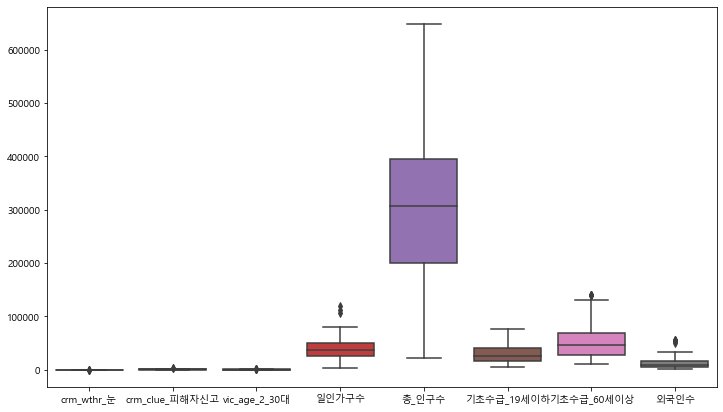

In [8]:
#이상치 확인
#극단값을  갖는  모습을 볼 수 있다 ->robustscale하면  좋을  듯  하다
plt.figure(figsize = (12,7))
sns.boxplot(data = df.iloc[:,:-1])

# 설명력 보기위한 모델링

In [9]:
# train, test 분리
X_train, X_test, y_train, y_test  = train_test_split(df.iloc[:,:-1], df["score_교통"],test_size = 0.3, random_state=0)

# ridge, lasso, elasticnet을 위한 alpha값 찾기 함수

In [10]:
def alphas_finder(model):
    alphas = [100, 10, 1, 0.1, 0.01, 0.001, 0.0001]
    for alpha in alphas:
        modeling = model(alpha=alpha)
        modeling.fit(X_train, y_train)
        print(alpha , ":" ,round(modeling.score(X_train, y_train),3)
              , round(modeling.score(X_test, y_test),3)
              ,"mae:",round(mean_absolute_error(modeling.predict(X_test), y_test),3))    

# 교차검증

In [11]:
X = np.array(df.drop('score_교통', 1))
Y = np.array(df['score_교통'])

In [12]:
from sklearn.model_selection import KFold

#kfold 설정
n_splits = 5
kfold = KFold(n_splits=n_splits, shuffle=True,random_state=0)

#mae kfold 교차검증 함수
def mae_kfold(model):
    i = 1
    total_error = 0
    for train_index, test_index in kfold.split(X):
        x_train_fold, x_test_fold = X[train_index], X[test_index]
        y_train_fold, y_test_fold = Y[train_index], Y[test_index]
        model_pred_fold = model.fit(x_train_fold, y_train_fold).predict(x_test_fold)
        error = mean_absolute_error(model_pred_fold, y_test_fold)
        print('Fold = {}, mae = {:.2f}'.format(i, error))
        total_error += error
        i+=1
    print('---'*10)
    print('Average Error: %s' % (total_error / n_splits))
    print('---'*10)

# 모델링

## 1. None scaling

In [13]:
#다중회귀
lr = LinearRegression()
lr.fit(X_train, y_train)
print(lr.score(X_train, y_train), lr.score(X_test, y_test),mean_absolute_error(lr.predict(X_test), y_test))

0.4187263237829285 0.40542434567235575 1.3192289268941877


In [10]:
# 다중회귀  교차검증
mae_kfold(lr)

Fold = 1, mae = 1.26
Fold = 2, mae = 1.69
Fold = 3, mae = 1.62
Fold = 4, mae = 1.50
Fold = 5, mae = 1.61
------------------------------
Average Error: 1.5381029129406305
------------------------------


## ridge

In [11]:
# ridge
alphas_finder(Ridge)

100 : 0.418 0.413 mae: 1.309
10 : 0.419 0.406 mae: 1.318
1 : 0.419 0.406 mae: 1.319
0.1 : 0.419 0.405 mae: 1.319
0.01 : 0.419 0.405 mae: 1.319
0.001 : 0.419 0.405 mae: 1.319
0.0001 : 0.419 0.405 mae: 1.319


In [12]:
#best: 1.35
for i in [100, 10, 1, 0.1, 0.01, 0.001, 0.0001]:
    ridge = Ridge(alpha=i)
    mae_kfold(ridge)

Fold = 1, mae = 1.26
Fold = 2, mae = 1.68
Fold = 3, mae = 1.58
Fold = 4, mae = 1.50
Fold = 5, mae = 1.62
------------------------------
Average Error: 1.5287454893932348
------------------------------
Fold = 1, mae = 1.26
Fold = 2, mae = 1.69
Fold = 3, mae = 1.62
Fold = 4, mae = 1.50
Fold = 5, mae = 1.61
------------------------------
Average Error: 1.5370417027777372
------------------------------
Fold = 1, mae = 1.26
Fold = 2, mae = 1.69
Fold = 3, mae = 1.62
Fold = 4, mae = 1.50
Fold = 5, mae = 1.61
------------------------------
Average Error: 1.5379955558192642
------------------------------
Fold = 1, mae = 1.26
Fold = 2, mae = 1.69
Fold = 3, mae = 1.62
Fold = 4, mae = 1.50
Fold = 5, mae = 1.61
------------------------------
Average Error: 1.5380921647051686
------------------------------
Fold = 1, mae = 1.26
Fold = 2, mae = 1.69
Fold = 3, mae = 1.62
Fold = 4, mae = 1.50
Fold = 5, mae = 1.61
------------------------------
Average Error: 1.5381018379917109
--------------------------

## Lasso

In [13]:
# lasso
alphas_finder(Lasso)

100 : 0.288 0.393 mae: 1.359
10 : 0.343 0.445 mae: 1.288
1 : 0.407 0.44 mae: 1.272
0.1 : 0.419 0.41 mae: 1.314
0.01 : 0.419 0.406 mae: 1.319
0.001 : 0.419 0.405 mae: 1.319
0.0001 : 0.419 0.405 mae: 1.319


In [14]:
for i in [100, 10, 1, 0.1, 0.01, 0.001, 0.0001]:
    lasso = Lasso(alpha=i)
    mae_kfold(lasso)

Fold = 1, mae = 1.28
Fold = 2, mae = 1.82
Fold = 3, mae = 1.52
Fold = 4, mae = 1.34
Fold = 5, mae = 1.78
------------------------------
Average Error: 1.5477036898186436
------------------------------
Fold = 1, mae = 1.23
Fold = 2, mae = 1.80
Fold = 3, mae = 1.49
Fold = 4, mae = 1.38
Fold = 5, mae = 1.80
------------------------------
Average Error: 1.5384668058121913
------------------------------
Fold = 1, mae = 1.23
Fold = 2, mae = 1.68
Fold = 3, mae = 1.49
Fold = 4, mae = 1.48
Fold = 5, mae = 1.77
------------------------------
Average Error: 1.5294306810743776
------------------------------
Fold = 1, mae = 1.26
Fold = 2, mae = 1.69
Fold = 3, mae = 1.60
Fold = 4, mae = 1.50
Fold = 5, mae = 1.63
------------------------------
Average Error: 1.5347253456427594
------------------------------
Fold = 1, mae = 1.26
Fold = 2, mae = 1.69
Fold = 3, mae = 1.62
Fold = 4, mae = 1.50
Fold = 5, mae = 1.61
------------------------------
Average Error: 1.5377519346637807
--------------------------

## ElasticNet

In [13]:
alphas_finder(ElasticNet)

100 : 0.296 0.383 mae: 1.366
10 : 0.35 0.452 mae: 1.261
1 : 0.415 0.428 mae: 1.289
0.1 : 0.419 0.408 mae: 1.316
0.01 : 0.419 0.406 mae: 1.319
0.001 : 0.419 0.405 mae: 1.319
0.0001 : 0.419 0.405 mae: 1.319


In [14]:

for i in [100, 10, 1, 0.1, 0.01, 0.001, 0.0001]:
    elastic = ElasticNet(alpha=i)
    mae_kfold(elastic)

Fold = 1, mae = 1.27
Fold = 2, mae = 1.86
Fold = 3, mae = 1.52
Fold = 4, mae = 1.34
Fold = 5, mae = 1.79
------------------------------
Average Error: 1.556202193532804
------------------------------
Fold = 1, mae = 1.22
Fold = 2, mae = 1.74
Fold = 3, mae = 1.49
Fold = 4, mae = 1.42
Fold = 5, mae = 1.78
------------------------------
Average Error: 1.5312748887786998
------------------------------
Fold = 1, mae = 1.24
Fold = 2, mae = 1.68
Fold = 3, mae = 1.50
Fold = 4, mae = 1.49
Fold = 5, mae = 1.71
------------------------------
Average Error: 1.5251810656016176
------------------------------
Fold = 1, mae = 1.26
Fold = 2, mae = 1.69
Fold = 3, mae = 1.61
Fold = 4, mae = 1.50
Fold = 5, mae = 1.62
------------------------------
Average Error: 1.5358995111007527
------------------------------
Fold = 1, mae = 1.26
Fold = 2, mae = 1.69
Fold = 3, mae = 1.62
Fold = 4, mae = 1.50
Fold = 5, mae = 1.61
------------------------------
Average Error: 1.5378750095399216
---------------------------

In [15]:
elastic = ElasticNet(alpha=1)
elastic.fit(X_train, y_train)

ElasticNet(alpha=1)

In [16]:
def plot_coef(columns, coef):
    coef_df = pd.DataFrame(list(zip(columns, coef)))
    coef_df.columns=['feature', 'coef']
    coef_df = coef_df.sort_values('coef').reset_index(drop=True)
    
    fig, ax = plt.subplots(figsize=(7, 5))
    ax.barh(np.arange(len(coef_df)), coef_df['coef'], color = "orange", alpha = 0.8)
    idx = np.arange(len(coef_df))
    ax.set_yticks(idx)
    ax.set_yticklabels(coef_df['feature'])
    fig.tight_layout()
    
    #plt.show()
    

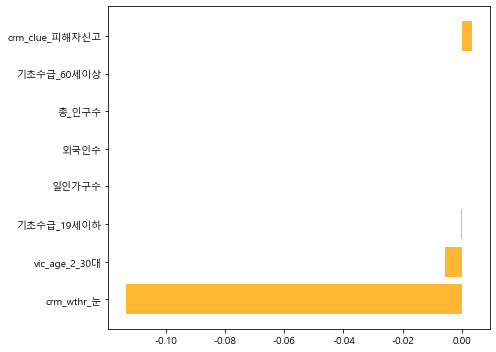

In [17]:
plot_coef(X_train.columns, np.ravel(elastic.coef_) )
plt.savefig('../이미지/변수영향도_교통사고안전도.png', dpi=200,bbox_inches='tight')

## XGboost

In [18]:
#XG boost
xgbr = XGBRegressor()
xgbr.fit(X_train, y_train)
print(xgbr.score(X_train, y_train), xgbr.score(X_test, y_test),mean_absolute_error(xgbr.predict(X_test), y_test))

0.9999998420461608 -0.06974470823560042 1.8067306106154981


In [19]:
#XG boost교차검증
mae_kfold(xgbr)

Fold = 1, mae = 1.93
Fold = 2, mae = 2.24
Fold = 3, mae = 1.47
Fold = 4, mae = 1.70
Fold = 5, mae = 2.22
------------------------------
Average Error: 1.9110195495605473
------------------------------


In [20]:
#XG boost 튜닝
xgbr = XGBRegressor(n_estimators = 400, learning_rate = 1, max_depth = 3, objective="reg:squarederror")
xgbr.fit(X_train, y_train)
print(xgbr.score(X_train, y_train), xgbr.score(X_test, y_test),mean_absolute_error(xgbr.predict(X_test), y_test))

0.9999999347294102 -0.38643122056620416 1.9139029425543714


In [21]:
#XG boost교차검증
mae_kfold(xgbr)

Fold = 1, mae = 2.25
Fold = 2, mae = 2.38
Fold = 3, mae = 1.99
Fold = 4, mae = 1.94
Fold = 5, mae = 2.51
------------------------------
Average Error: 2.213843765258789
------------------------------


## lightgbm

In [22]:
#lightgbm
lgbm = LGBMRegressor()
lgbm.fit(X_train, y_train)
print(lgbm.score(X_train, y_train), lgbm.score(X_test, y_test),mean_absolute_error(lgbm.predict(X_test), y_test))

0.5601816071984563 -0.05161761017314559 1.9100037061703243


In [23]:
#lightgbm교차검증
mae_kfold(xgbr)

Fold = 1, mae = 2.25
Fold = 2, mae = 2.38
Fold = 3, mae = 1.99
Fold = 4, mae = 1.94
Fold = 5, mae = 2.51
------------------------------
Average Error: 2.213843765258789
------------------------------


-----------
# 2. Scaling

### 각변수 minmaxscaling



In [24]:
#각 변수들을 스케일링 하는 함수

def minmax_scaling(df, scale_columns):
    for col in scale_columns:
        series_min = df[col].min()
        series_max = df[col].max()
        df[col] = df[col].apply(lambda x: (x-series_min)/(series_max-series_min))
        
            
    return df

In [25]:
df.columns

Index(['crm_wthr_눈', 'crm_clue_피해자신고', 'vic_age_2_30대', '일인가구수', '총_인구수',
       '기초수급_19세이하', '기초수급_60세이상', '외국인수', 'score_교통'],
      dtype='object')

In [26]:
minmax_scaling(df, df.columns[:-1])

,crm_wthr_눈,crm_clue_피해자신고,vic_age_2_30대,일인가구수,총_인구수,기초수급_19세이하,기초수급_60세이상,외국인수,score_교통
0,0.586207,0.742845,0.797970,0.423996,0.760807,0.476709,0.303802,0.244742,69.00
1,0.344828,0.111448,0.168819,0.216117,0.428320,0.476709,0.303802,0.405098,66.40
2,0.241379,0.427580,0.448339,0.323532,0.623217,0.476709,0.303802,0.312075,69.55
3,0.000000,0.016912,0.051661,0.143554,0.287674,0.698292,0.429417,0.041001,64.45
4,0.000000,0.024718,0.041513,0.155186,0.287674,0.698292,0.429417,0.024205,70.20
...,...,...,...,...,...,...,...,...,...
118,0.034483,0.176930,0.177122,0.179222,0.268720,0.368079,0.450655,0.094673,71.25
119,0.034483,0.415872,0.362546,0.418713,0.580871,0.580343,0.631077,0.143706,67.35
120,0.000000,0.117086,0.143911,0.130084,0.128590,0.023831,0.133553,0.175080,67.95
121,0.034483,0.109714,0.118081,0.323076,0.083866,0.008716,0.112199,0.159402,68.60


# 설명력 보기위한 모델링

In [27]:
# train, test 분리
X_train, X_test, y_train, y_test  = train_test_split(df.iloc[:,:-1], df["score_교통"],test_size = 0.3, random_state=0)

In [28]:
X = np.array(df.drop('score_교통', 1))
Y = np.array(df['score_교통'])

In [29]:
#다중회귀
lr = LinearRegression()
lr.fit(X_train, y_train)
print(lr.score(X_train, y_train), lr.score(X_test, y_test),mean_absolute_error(lr.predict(X_test), y_test))

0.4187263237829292 0.4054243456723481 1.3192289268941984


In [30]:
# 다중회귀  교차검증
mae_kfold(lr)

Fold = 1, mae = 1.26
Fold = 2, mae = 1.69
Fold = 3, mae = 1.62
Fold = 4, mae = 1.50
Fold = 5, mae = 1.61
------------------------------
Average Error: 1.5381029129406563
------------------------------


## ridge

In [31]:
# ridge
alphas_finder(Ridge)

100 : 0.02 0.002 mae: 1.841
10 : 0.117 0.059 mae: 1.807
1 : 0.302 0.185 mae: 1.657
0.1 : 0.406 0.349 mae: 1.42
0.01 : 0.418 0.4 mae: 1.331
0.001 : 0.419 0.405 mae: 1.321
0.0001 : 0.419 0.405 mae: 1.319


In [32]:
for i in [100, 10, 1, 0.1, 0.01, 0.001, 0.0001]:
    ridge = Ridge(alpha=i)
    mae_kfold(ridge)

Fold = 1, mae = 1.70
Fold = 2, mae = 2.18
Fold = 3, mae = 1.55
Fold = 4, mae = 1.53
Fold = 5, mae = 2.07
------------------------------
Average Error: 1.8056573589672147
------------------------------
Fold = 1, mae = 1.69
Fold = 2, mae = 2.16
Fold = 3, mae = 1.50
Fold = 4, mae = 1.51
Fold = 5, mae = 1.96
------------------------------
Average Error: 1.764843951897427
------------------------------
Fold = 1, mae = 1.57
Fold = 2, mae = 2.03
Fold = 3, mae = 1.34
Fold = 4, mae = 1.46
Fold = 5, mae = 1.71
------------------------------
Average Error: 1.6214875907917594
------------------------------
Fold = 1, mae = 1.32
Fold = 2, mae = 1.80
Fold = 3, mae = 1.47
Fold = 4, mae = 1.43
Fold = 5, mae = 1.62
------------------------------
Average Error: 1.5286498822291401
------------------------------
Fold = 1, mae = 1.27
Fold = 2, mae = 1.70
Fold = 3, mae = 1.61
Fold = 4, mae = 1.49
Fold = 5, mae = 1.61
------------------------------
Average Error: 1.5366348982682996
---------------------------

## Lasso

In [33]:
# lasso
alphas_finder(Lasso)

100 : 0.0 -0.011 mae: 1.845
10 : 0.0 -0.011 mae: 1.845
1 : 0.0 -0.011 mae: 1.845
0.1 : 0.062 0.017 mae: 1.851
0.01 : 0.38 0.242 mae: 1.557
0.001 : 0.418 0.396 mae: 1.338
0.0001 : 0.419 0.405 mae: 1.321


In [34]:

for i in [100, 10, 1, 0.1, 0.01, 0.001, 0.0001]:
    lasso = Lasso(alpha=i)
    mae_kfold(lasso)

Fold = 1, mae = 1.70
Fold = 2, mae = 2.18
Fold = 3, mae = 1.56
Fold = 4, mae = 1.52
Fold = 5, mae = 2.09
------------------------------
Average Error: 1.810733065347351
------------------------------
Fold = 1, mae = 1.70
Fold = 2, mae = 2.18
Fold = 3, mae = 1.56
Fold = 4, mae = 1.52
Fold = 5, mae = 2.09
------------------------------
Average Error: 1.810733065347351
------------------------------
Fold = 1, mae = 1.70
Fold = 2, mae = 2.18
Fold = 3, mae = 1.56
Fold = 4, mae = 1.52
Fold = 5, mae = 2.09
------------------------------
Average Error: 1.810733065347351
------------------------------
Fold = 1, mae = 1.70
Fold = 2, mae = 2.19
Fold = 3, mae = 1.54
Fold = 4, mae = 1.52
Fold = 5, mae = 2.04
------------------------------
Average Error: 1.7971083427788765
------------------------------
Fold = 1, mae = 1.44
Fold = 2, mae = 1.92
Fold = 3, mae = 1.37
Fold = 4, mae = 1.44
Fold = 5, mae = 1.71
------------------------------
Average Error: 1.5765535846017247
-----------------------------

## ElasticNet

In [35]:
alphas_finder(ElasticNet)

100 : 0.0 -0.011 mae: 1.845
10 : 0.0 -0.011 mae: 1.845
1 : 0.0 -0.011 mae: 1.845
0.1 : 0.103 0.05 mae: 1.818
0.01 : 0.337 0.212 mae: 1.612
0.001 : 0.414 0.374 mae: 1.371
0.0001 : 0.419 0.403 mae: 1.326


In [36]:

for i in [100, 10, 1, 0.1, 0.01, 0.001, 0.0001]:
    elastic = ElasticNet(alpha=i)
    mae_kfold(elastic)

Fold = 1, mae = 1.70
Fold = 2, mae = 2.18
Fold = 3, mae = 1.56
Fold = 4, mae = 1.52
Fold = 5, mae = 2.09
------------------------------
Average Error: 1.810733065347351
------------------------------
Fold = 1, mae = 1.70
Fold = 2, mae = 2.18
Fold = 3, mae = 1.56
Fold = 4, mae = 1.52
Fold = 5, mae = 2.09
------------------------------
Average Error: 1.810733065347351
------------------------------
Fold = 1, mae = 1.70
Fold = 2, mae = 2.18
Fold = 3, mae = 1.56
Fold = 4, mae = 1.52
Fold = 5, mae = 2.09
------------------------------
Average Error: 1.810733065347351
------------------------------
Fold = 1, mae = 1.70
Fold = 2, mae = 2.14
Fold = 3, mae = 1.53
Fold = 4, mae = 1.50
Fold = 5, mae = 1.99
------------------------------
Average Error: 1.7724210562597105
------------------------------
Fold = 1, mae = 1.54
Fold = 2, mae = 1.97
Fold = 3, mae = 1.32
Fold = 4, mae = 1.45
Fold = 5, mae = 1.68
------------------------------
Average Error: 1.5937487660362704
-----------------------------

## XGboost

In [37]:
#XG boost
xgbr = XGBRegressor()
xgbr.fit(X_train, y_train)
print(xgbr.score(X_train, y_train), xgbr.score(X_test, y_test),mean_absolute_error(xgbr.predict(X_test), y_test))

0.9999998420461608 -0.06974470823560042 1.8067306106154981


In [38]:
#XG boost교차검증
mae_kfold(xgbr)

Fold = 1, mae = 1.92
Fold = 2, mae = 2.24
Fold = 3, mae = 1.52
Fold = 4, mae = 1.70
Fold = 5, mae = 2.22
------------------------------
Average Error: 1.921580889892579
------------------------------


In [39]:
#XG boost 튜닝
xgbr = XGBRegressor(n_estimators = 400, learning_rate = 1, max_depth = 3, objective="reg:squarederror")
xgbr.fit(X_train, y_train)
print(xgbr.score(X_train, y_train), xgbr.score(X_test, y_test),mean_absolute_error(xgbr.predict(X_test), y_test))

0.9999999347294102 -0.38643122056620416 1.9139029425543714


In [40]:
#XG boost교차검증
mae_kfold(xgbr)

Fold = 1, mae = 2.25
Fold = 2, mae = 2.38
Fold = 3, mae = 1.99
Fold = 4, mae = 1.94
Fold = 5, mae = 2.51
------------------------------
Average Error: 2.213945426940918
------------------------------


## lightgbm

In [41]:
#lightgbm
lgbm = LGBMRegressor()
lgbm.fit(X_train, y_train)
print(lgbm.score(X_train, y_train), lgbm.score(X_test, y_test),mean_absolute_error(lgbm.predict(X_test), y_test))

0.5413438735826817 -0.09206938212830273 1.9568720260553343


In [42]:
#lightgbm교차검증
mae_kfold(lgbm)

Fold = 1, mae = 1.94
Fold = 2, mae = 2.54
Fold = 3, mae = 1.59
Fold = 4, mae = 1.68
Fold = 5, mae = 1.70
------------------------------
Average Error: 1.8911311809472384
------------------------------


In [43]:
#SVR
svr = SVR(kernel="linear")
svr.fit(X_train, y_train)

print("학습 결과 : ", svr.score(X_train, y_train))
print("테스트 결과 : ", svr.score(X_test, y_test))
print("테스트 결과 : ", mean_absolute_error(svr.predict(X_test), y_test))

학습 결과 :  0.22461517261288777
테스트 결과 :  0.11404309789593514
테스트 결과 :  1.7427204831603869


In [44]:
mae_kfold(svr)

Fold = 1, mae = 1.59
Fold = 2, mae = 2.12
Fold = 3, mae = 1.56
Fold = 4, mae = 1.44
Fold = 5, mae = 1.82
------------------------------
Average Error: 1.703565512393444
------------------------------


# standardscaling

#### 변수마다 Standard Scaling



In [47]:
#각 변수들을 스케일링 하는 함수

def standard_scaling(df, scale_columns):
    for col in scale_columns:
        series_mean = df[col].mean()
        series_std = df[col].std()
        df[col] = df[col].apply(lambda x: (x-series_mean)/series_std)
        
    return df

In [48]:
df.iloc[:,:-1].columns

Index(['crm_wthr_눈', 'crm_clue_피해자신고', 'vic_age_2_30대', '일인가구수', '총_인구수',
       '기초수급_19세이하', '기초수급_60세이상', '외국인수'],
      dtype='object')

In [49]:
standard_scaling(df, df.iloc[:,:-1].columns)

,crm_wthr_눈,crm_clue_피해자신고,vic_age_2_30대,일인가구수,총_인구수,기초수급_19세이하,기초수급_60세이상,외국인수,score_교통
0,2.928534,2.353164,2.238959,0.703653,1.391783,0.422364,-0.147244,0.159691,69.00
1,1.336698,-0.709239,-0.508314,-0.559382,-0.142624,0.422364,-0.147244,0.889381,66.40
2,0.654483,0.824066,0.712249,0.093248,0.756811,0.422364,-0.147244,0.466086,69.55
3,-0.937353,-1.167758,-1.019903,-1.000262,-0.791697,1.224555,0.340403,-0.767420,64.45
4,-0.937353,-1.129899,-1.064214,-0.929592,-0.791697,1.224555,0.340403,-0.843852,70.20
...,...,...,...,...,...,...,...,...,...
118,-0.709948,-0.391641,-0.472060,-0.783554,-0.879166,0.029093,0.422849,-0.523189,71.25
119,-0.709948,0.767277,0.337621,0.671554,0.561386,0.797546,1.123263,-0.300068,67.35
120,-0.937353,-0.681896,-0.617077,-1.082101,-1.525857,-1.217180,-0.808163,-0.157301,67.95
121,-0.709948,-0.717652,-0.729868,0.090482,-1.732256,-1.271902,-0.891059,-0.228643,68.60


# 설명력 보기위한 모델링

In [50]:
# train, test 분리
X_train, X_test, y_train, y_test  = train_test_split(df.iloc[:,:-1], df["score_교통"],test_size = 0.3, random_state=0)

In [51]:
X = np.array(df.drop('score_교통', 1))
Y = np.array(df['score_교통'])

In [52]:
#다중회귀
lr = LinearRegression()
lr.fit(X_train, y_train)
print(lr.score(X_train, y_train), lr.score(X_test, y_test),mean_absolute_error(lr.predict(X_test), y_test))

0.4187263237829286 0.4054243456723483 1.3192289268941984


In [53]:
# 다중회귀  교차검증
mae_kfold(lr)

Fold = 1, mae = 1.26
Fold = 2, mae = 1.69
Fold = 3, mae = 1.62
Fold = 4, mae = 1.50
Fold = 5, mae = 1.61
------------------------------
Average Error: 1.5381029129406563
------------------------------


## ridge

In [54]:
# ridge
alphas_finder(Ridge)

100 : 0.202 0.073 mae: 1.784
10 : 0.353 0.199 mae: 1.61
1 : 0.414 0.365 mae: 1.385
0.1 : 0.419 0.401 mae: 1.327
0.01 : 0.419 0.405 mae: 1.32
0.001 : 0.419 0.405 mae: 1.319
0.0001 : 0.419 0.405 mae: 1.319


In [55]:
for i in [100, 10, 1, 0.1, 0.01, 0.001, 0.0001]:
    ridge = Ridge(alpha=i)
    mae_kfold(ridge)

Fold = 1, mae = 1.70
Fold = 2, mae = 2.13
Fold = 3, mae = 1.43
Fold = 4, mae = 1.49
Fold = 5, mae = 1.89
------------------------------
Average Error: 1.728329632061375
------------------------------
Fold = 1, mae = 1.53
Fold = 2, mae = 1.98
Fold = 3, mae = 1.30
Fold = 4, mae = 1.41
Fold = 5, mae = 1.64
------------------------------
Average Error: 1.570381949793214
------------------------------
Fold = 1, mae = 1.30
Fold = 2, mae = 1.76
Fold = 3, mae = 1.55
Fold = 4, mae = 1.46
Fold = 5, mae = 1.60
------------------------------
Average Error: 1.5335233806252897
------------------------------
Fold = 1, mae = 1.27
Fold = 2, mae = 1.70
Fold = 3, mae = 1.61
Fold = 4, mae = 1.50
Fold = 5, mae = 1.61
------------------------------
Average Error: 1.5375030631524733
------------------------------
Fold = 1, mae = 1.26
Fold = 2, mae = 1.69
Fold = 3, mae = 1.62
Fold = 4, mae = 1.50
Fold = 5, mae = 1.61
------------------------------
Average Error: 1.538037481682645
-----------------------------

## Lasso

In [56]:
# lasso
alphas_finder(Lasso)

100 : 0.0 -0.011 mae: 1.845
10 : 0.0 -0.011 mae: 1.845
1 : 0.0 -0.011 mae: 1.845
0.1 : 0.323 0.108 mae: 1.727
0.01 : 0.416 0.377 mae: 1.366
0.001 : 0.419 0.403 mae: 1.324
0.0001 : 0.419 0.405 mae: 1.32


In [57]:

for i in [100, 10, 1, 0.1, 0.01, 0.001, 0.0001]:
    lasso = Lasso(alpha=i)
    mae_kfold(lasso)

Fold = 1, mae = 1.70
Fold = 2, mae = 2.18
Fold = 3, mae = 1.56
Fold = 4, mae = 1.52
Fold = 5, mae = 2.09
------------------------------
Average Error: 1.810733065347351
------------------------------
Fold = 1, mae = 1.70
Fold = 2, mae = 2.18
Fold = 3, mae = 1.56
Fold = 4, mae = 1.52
Fold = 5, mae = 2.09
------------------------------
Average Error: 1.810733065347351
------------------------------
Fold = 1, mae = 1.70
Fold = 2, mae = 2.18
Fold = 3, mae = 1.56
Fold = 4, mae = 1.52
Fold = 5, mae = 2.09
------------------------------
Average Error: 1.810733065347351
------------------------------
Fold = 1, mae = 1.63
Fold = 2, mae = 2.07
Fold = 3, mae = 1.30
Fold = 4, mae = 1.51
Fold = 5, mae = 1.73
------------------------------
Average Error: 1.6473118246592253
------------------------------
Fold = 1, mae = 1.29
Fold = 2, mae = 1.75
Fold = 3, mae = 1.57
Fold = 4, mae = 1.49
Fold = 5, mae = 1.62
------------------------------
Average Error: 1.5447935338268983
-----------------------------

## ElasticNet

In [58]:
alphas_finder(ElasticNet)

100 : 0.0 -0.011 mae: 1.845
10 : 0.0 -0.011 mae: 1.845
1 : 0.058 -0.015 mae: 1.849
0.1 : 0.345 0.163 mae: 1.656
0.01 : 0.415 0.373 mae: 1.37
0.001 : 0.419 0.403 mae: 1.325
0.0001 : 0.419 0.405 mae: 1.32


In [59]:

for i in [100, 10, 1, 0.1, 0.01, 0.001, 0.0001]:
    elastic = ElasticNet(alpha=i)
    mae_kfold(elastic)

Fold = 1, mae = 1.70
Fold = 2, mae = 2.18
Fold = 3, mae = 1.56
Fold = 4, mae = 1.52
Fold = 5, mae = 2.09
------------------------------
Average Error: 1.810733065347351
------------------------------
Fold = 1, mae = 1.70
Fold = 2, mae = 2.18
Fold = 3, mae = 1.56
Fold = 4, mae = 1.52
Fold = 5, mae = 2.09
------------------------------
Average Error: 1.810733065347351
------------------------------
Fold = 1, mae = 1.73
Fold = 2, mae = 2.17
Fold = 3, mae = 1.56
Fold = 4, mae = 1.52
Fold = 5, mae = 2.09
------------------------------
Average Error: 1.8141784046167941
------------------------------
Fold = 1, mae = 1.57
Fold = 2, mae = 2.00
Fold = 3, mae = 1.29
Fold = 4, mae = 1.45
Fold = 5, mae = 1.69
------------------------------
Average Error: 1.5998155857154794
------------------------------
Fold = 1, mae = 1.29
Fold = 2, mae = 1.76
Fold = 3, mae = 1.56
Fold = 4, mae = 1.47
Fold = 5, mae = 1.61
------------------------------
Average Error: 1.5387161330558126
----------------------------

## XGboost

In [60]:
#XG boost
xgbr = XGBRegressor()
xgbr.fit(X_train, y_train)
print(xgbr.score(X_train, y_train), xgbr.score(X_test, y_test),mean_absolute_error(xgbr.predict(X_test), y_test))

0.9999998420461608 -0.07031474147670402 1.8071374429238807


In [61]:
#XG boost교차검증
mae_kfold(xgbr)

Fold = 1, mae = 1.93
Fold = 2, mae = 2.24
Fold = 3, mae = 1.47
Fold = 4, mae = 1.71
Fold = 5, mae = 2.22
------------------------------
Average Error: 1.9134536087036138
------------------------------


In [62]:
#XG boost 튜닝
xgbr = XGBRegressor(n_estimators = 400, learning_rate = 1, max_depth = 3, objective="reg:squarederror")
xgbr.fit(X_train, y_train)
print(xgbr.score(X_train, y_train), xgbr.score(X_test, y_test),mean_absolute_error(xgbr.predict(X_test), y_test))

0.9999999347294102 -0.4012853030804884 1.9436739947344814


In [63]:
#XG boost교차검증
mae_kfold(xgbr)

Fold = 1, mae = 2.25
Fold = 2, mae = 2.36
Fold = 3, mae = 1.99
Fold = 4, mae = 1.94
Fold = 5, mae = 2.51
------------------------------
Average Error: 2.2097032623291013
------------------------------


## lightgbm

In [64]:
#lightgbm
lgbm = LGBMRegressor()
lgbm.fit(X_train, y_train)
print(lgbm.score(X_train, y_train), lgbm.score(X_test, y_test),mean_absolute_error(lgbm.predict(X_test), y_test))

0.5989238078231851 -0.023026544120603898 1.870915972162888


In [65]:
#lightgbm교차검증
mae_kfold(lgbm)

Fold = 1, mae = 1.99
Fold = 2, mae = 2.55
Fold = 3, mae = 1.55
Fold = 4, mae = 1.60
Fold = 5, mae = 1.80
------------------------------
Average Error: 1.8986476323203234
------------------------------


In [66]:
#SVR
svr = SVR(kernel="linear")
svr.fit(X_train, y_train)

print("학습 결과 : ", svr.score(X_train, y_train))
print("테스트 결과 : ", svr.score(X_test, y_test))
print("테스트 결과 : ", mean_absolute_error(svr.predict(X_test), y_test))

학습 결과 :  0.3621706783152342
테스트 결과 :  0.2589515825171993
테스트 결과 :  1.4995714993128244


In [67]:
#best
mae_kfold(svr) 

Fold = 1, mae = 1.40
Fold = 2, mae = 1.83
Fold = 3, mae = 1.46
Fold = 4, mae = 1.40
Fold = 5, mae = 1.57
------------------------------
Average Error: 1.5306756962637458
------------------------------


# RobustScaler

### 각변수 robustscaling



In [78]:
#각 변수들을 스케일링 하는 함수

def robust_scaling(df, scale_columns):
    for col in scale_columns:
        series_med = df[col].median()
        series_per75 = np.percentile(df[col],75)
        series_per25 = np.percentile(df[col],25)
        df[col] = df[col].apply(lambda x: (x-series_med)/(series_per75-series_per25))
        
            
    return df

In [79]:
df.iloc[:,:-1].columns

Index(['crm_wthr_눈', 'crm_clue_피해자신고', 'vic_age_2_30대', '일인가구수', '총_인구수',
       '기초수급_19세이하', '기초수급_60세이상', '외국인수'],
      dtype='object')

In [80]:

robust_scaling(df, df.iloc[:,:-1].columns)

,crm_wthr_눈,crm_clue_피해자신고,vic_age_2_30대,일인가구수,총_인구수,기초수급_19세이하,기초수급_60세이상,외국인수,score_교통
0,2.8,2.052548,2.043956,0.664721,0.988267,0.558545,0.100498,0.550122,69.00
1,1.4,-0.265924,-0.097331,-0.405297,-0.081904,0.558545,0.100498,1.315080,66.40
2,0.8,0.894904,0.854003,0.147598,0.545406,0.558545,0.100498,0.871326,69.55
3,-0.6,-0.613057,-0.496075,-0.778802,-0.534599,1.192499,0.496633,-0.421798,64.45
4,-0.6,-0.584395,-0.530612,-0.718932,-0.534599,1.192499,0.496633,-0.501924,70.20
...,...,...,...,...,...,...,...,...,...
118,-0.4,-0.025478,-0.069074,-0.595211,-0.595604,0.247751,0.563607,-0.165763,71.25
119,-0.4,0.851911,0.562009,0.637527,0.409108,0.855043,1.132582,0.068142,67.35
120,-0.6,-0.245223,-0.182104,-0.848135,-1.046638,-0.737151,-0.436393,0.217810,67.95
121,-0.4,-0.272293,-0.270016,0.145254,-1.190591,-0.780397,-0.503733,0.143020,68.60


# 설명력 보기위한 모델링

In [81]:
# train, test 분리
X_train, X_test, y_train, y_test  = train_test_split(df.iloc[:,:-1], df["score_교통"],test_size = 0.3, random_state=0)

In [82]:
X = np.array(df.drop('score_교통', 1))
Y = np.array(df['score_교통'])

In [83]:
#다중회귀
lr = LinearRegression()
lr.fit(X_train, y_train)
print(lr.score(X_train, y_train), lr.score(X_test, y_test),mean_absolute_error(lr.predict(X_test), y_test))

0.4187263237829293 0.40542434567234764 1.3192289268941988


In [84]:
# 다중회귀  교차검증
mae_kfold(lr)

Fold = 1, mae = 1.26
Fold = 2, mae = 1.69
Fold = 3, mae = 1.62
Fold = 4, mae = 1.50
Fold = 5, mae = 1.61
------------------------------
Average Error: 1.5381029129406563
------------------------------


## ridge

In [85]:
# ridge
alphas_finder(Ridge)

100 : 0.173 0.064 mae: 1.784
10 : 0.33 0.164 mae: 1.651
1 : 0.408 0.342 mae: 1.426
0.1 : 0.419 0.399 mae: 1.332
0.01 : 0.419 0.405 mae: 1.321
0.001 : 0.419 0.405 mae: 1.319
0.0001 : 0.419 0.405 mae: 1.319


In [86]:

for i in [100, 10, 1, 0.1, 0.01, 0.001, 0.0001]:
    ridge = Ridge(alpha=i)
    mae_kfold(ridge)

Fold = 1, mae = 1.71
Fold = 2, mae = 2.12
Fold = 3, mae = 1.46
Fold = 4, mae = 1.49
Fold = 5, mae = 1.92
------------------------------
Average Error: 1.739480529388691
------------------------------
Fold = 1, mae = 1.58
Fold = 2, mae = 2.02
Fold = 3, mae = 1.30
Fold = 4, mae = 1.44
Fold = 5, mae = 1.67
------------------------------
Average Error: 1.600776021283713
------------------------------
Fold = 1, mae = 1.32
Fold = 2, mae = 1.80
Fold = 3, mae = 1.51
Fold = 4, mae = 1.44
Fold = 5, mae = 1.60
------------------------------
Average Error: 1.533595822122185
------------------------------
Fold = 1, mae = 1.27
Fold = 2, mae = 1.70
Fold = 3, mae = 1.61
Fold = 4, mae = 1.50
Fold = 5, mae = 1.61
------------------------------
Average Error: 1.5372350830516255
------------------------------
Fold = 1, mae = 1.26
Fold = 2, mae = 1.69
Fold = 3, mae = 1.62
Fold = 4, mae = 1.50
Fold = 5, mae = 1.61
------------------------------
Average Error: 1.5380058221861184
-----------------------------

## Lasso

In [87]:
# lasso
alphas_finder(Lasso)

100 : 0.0 -0.011 mae: 1.845
10 : 0.0 -0.011 mae: 1.845
1 : 0.0 -0.011 mae: 1.845
0.1 : 0.303 0.106 mae: 1.736
0.01 : 0.415 0.368 mae: 1.377
0.001 : 0.419 0.403 mae: 1.325
0.0001 : 0.419 0.405 mae: 1.32


In [88]:

for i in [100, 10, 1, 0.1, 0.01, 0.001, 0.0001]:
    lasso = Lasso(alpha=i)
    mae_kfold(lasso)

Fold = 1, mae = 1.70
Fold = 2, mae = 2.18
Fold = 3, mae = 1.56
Fold = 4, mae = 1.52
Fold = 5, mae = 2.09
------------------------------
Average Error: 1.810733065347351
------------------------------
Fold = 1, mae = 1.70
Fold = 2, mae = 2.18
Fold = 3, mae = 1.56
Fold = 4, mae = 1.52
Fold = 5, mae = 2.09
------------------------------
Average Error: 1.810733065347351
------------------------------
Fold = 1, mae = 1.70
Fold = 2, mae = 2.18
Fold = 3, mae = 1.56
Fold = 4, mae = 1.52
Fold = 5, mae = 2.09
------------------------------
Average Error: 1.810733065347351
------------------------------
Fold = 1, mae = 1.66
Fold = 2, mae = 2.08
Fold = 3, mae = 1.38
Fold = 4, mae = 1.50
Fold = 5, mae = 1.77
------------------------------
Average Error: 1.676816810094817
------------------------------
Fold = 1, mae = 1.30
Fold = 2, mae = 1.77
Fold = 3, mae = 1.56
Fold = 4, mae = 1.49
Fold = 5, mae = 1.62
------------------------------
Average Error: 1.5476297094130964
------------------------------

## ElasticNet

In [89]:
alphas_finder(ElasticNet)

100 : 0.0 -0.011 mae: 1.845
10 : 0.0 -0.011 mae: 1.845
1 : 0.033 -0.02 mae: 1.852
0.1 : 0.322 0.134 mae: 1.696
0.01 : 0.412 0.357 mae: 1.398
0.001 : 0.419 0.401 mae: 1.328
0.0001 : 0.419 0.405 mae: 1.32


In [90]:

for i in [100, 10, 1, 0.1, 0.01, 0.001, 0.0001]:
    elastic = ElasticNet(alpha=i)
    mae_kfold(elastic)

Fold = 1, mae = 1.70
Fold = 2, mae = 2.18
Fold = 3, mae = 1.56
Fold = 4, mae = 1.52
Fold = 5, mae = 2.09
------------------------------
Average Error: 1.810733065347351
------------------------------
Fold = 1, mae = 1.70
Fold = 2, mae = 2.18
Fold = 3, mae = 1.56
Fold = 4, mae = 1.52
Fold = 5, mae = 2.09
------------------------------
Average Error: 1.810733065347351
------------------------------
Fold = 1, mae = 1.72
Fold = 2, mae = 2.18
Fold = 3, mae = 1.56
Fold = 4, mae = 1.52
Fold = 5, mae = 2.09
------------------------------
Average Error: 1.814330542793316
------------------------------
Fold = 1, mae = 1.61
Fold = 2, mae = 2.05
Fold = 3, mae = 1.31
Fold = 4, mae = 1.49
Fold = 5, mae = 1.71
------------------------------
Average Error: 1.6339570011346658
------------------------------
Fold = 1, mae = 1.31
Fold = 2, mae = 1.79
Fold = 3, mae = 1.53
Fold = 4, mae = 1.46
Fold = 5, mae = 1.61
------------------------------
Average Error: 1.539180730429289
------------------------------

## XGboost

In [91]:
#XG boost
xgbr = XGBRegressor()
xgbr.fit(X_train, y_train)
print(xgbr.score(X_train, y_train), xgbr.score(X_test, y_test),mean_absolute_error(xgbr.predict(X_test), y_test))

0.9999998420461608 -0.06974470823560042 1.8067306106154981


In [92]:
#XG boost교차검증
mae_kfold(xgbr)

Fold = 1, mae = 1.93
Fold = 2, mae = 2.24
Fold = 3, mae = 1.47
Fold = 4, mae = 1.70
Fold = 5, mae = 2.22
------------------------------
Average Error: 1.910550006103516
------------------------------


In [93]:
#XG boost 튜닝
xgbr = XGBRegressor(n_estimators = 400, learning_rate = 1, max_depth = 3, objective="reg:squarederror")
xgbr.fit(X_train, y_train)
print(xgbr.score(X_train, y_train), xgbr.score(X_test, y_test),mean_absolute_error(xgbr.predict(X_test), y_test))

0.9999999347294102 -0.38643122056620416 1.9139029425543714


In [94]:
#XG boost교차검증
mae_kfold(xgbr)

Fold = 1, mae = 2.25
Fold = 2, mae = 2.38
Fold = 3, mae = 1.99
Fold = 4, mae = 1.94
Fold = 5, mae = 2.51
------------------------------
Average Error: 2.213843765258789
------------------------------


## lightgbm

In [95]:
#lightgbm
lgbm = LGBMRegressor()
lgbm.fit(X_train, y_train)
print(lgbm.score(X_train, y_train), lgbm.score(X_test, y_test),mean_absolute_error(lgbm.predict(X_test), y_test))

0.5736237837235472 -0.03235825924853741 1.9084920481729417


In [96]:
#lightgbm교차검증
mae_kfold(lgbm)

Fold = 1, mae = 1.96
Fold = 2, mae = 2.53
Fold = 3, mae = 1.57
Fold = 4, mae = 1.62
Fold = 5, mae = 1.79
------------------------------
Average Error: 1.8941198311801
------------------------------


In [97]:
#SVR
svr = SVR(kernel="linear")
svr.fit(X_train, y_train)

print("학습 결과 : ", svr.score(X_train, y_train))
print("테스트 결과 : ", svr.score(X_test, y_test))
print("테스트 결과 : ", mean_absolute_error(svr.predict(X_test), y_test))

학습 결과 :  0.35695652334821826
테스트 결과 :  0.2499950342809697
테스트 결과 :  1.5066763837187105


In [98]:
mae_kfold(svr)

Fold = 1, mae = 1.44
Fold = 2, mae = 1.81
Fold = 3, mae = 1.39
Fold = 4, mae = 1.42
Fold = 5, mae = 1.57
------------------------------
Average Error: 1.5272762127248525
------------------------------
